# GAN 구성 및 학습

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU)
from tensorflow.keras.models import Sequential, Model

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train data size :  (60000, 28, 28)
이미지 샘플


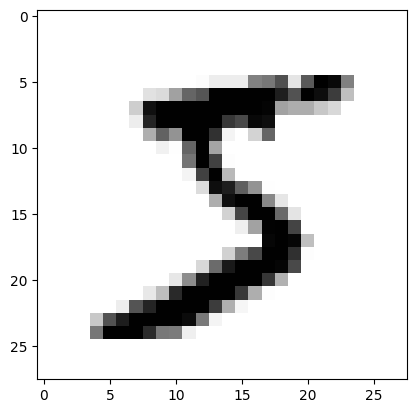

In [ ]:
from tensorflow.keras.datasets import mnist ## mnist 데이터셋
# (train_data, train_label), (test_data, test_label) = mnist.load_data()
# -> mnist에 저장된 train,과 test에 사용할 데이터와 정답을 (train_data, train_label), (test_data, test_label)에 저장함을 의미
#-> GAN에서는 train_data만 사용
(train_data, _), (_, _) = mnist.load_data()
train_data = (train_data.astype(np.float32) - 127.5) / 127.5  # 픽셀값은 0-255 -> [-1, 1] 범위의 픽셀값 생성
print("Train data size : ",np.shape(train_data))
plt.imshow(train_data[0], cmap='gray_r')  # 첫 번째 이미지를 흑백으로 출력
print("이미지 샘플")
plt.show()

In [ ]:
# 하이퍼 파라미터
img_shape = (28, 28, 1)
latent_dim = 10 #latent_dim=생성자 모델이 입력으로 받는 잠재공간의 차원
epochs = 200 #훈련횟수
batch_size = 64 #step마다 학습하는 데이터의 양
sample_interval = 10 #학습 진행상황(생성자가 생성하는 이미지)를 확인하는 간격

from tensorflow.keras.optimizers import Adam
adam_dis = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
adam_gan = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
#생성자 정의
def make_generator(latent_dim):
    model = Sequential()
    model.add(Input(shape=(latent_dim,)))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))
    model.add(Dense(784,activation='tanh')) # 생성자의 최종 layer의 output size = 784로 정의 <- 이미지에 사용되는 픽셀의 수가 28*28=784이기 때문
    model.add(Reshape((28, 28)))  #이미지의 형태로 재정의
    return model

In [ ]:
# 판별자 정의
def make_discriminator():
    model = Sequential()

    # 입력은 28x28x1
    model.add(Input(shape=(28,28)))
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid')) # 판별자는 true or false를 판별 -> output_size = 1

    return model

In [ ]:
# 생성된 이미지 시각화 함수

def visualize_generated_images(generator, latent_dim, epoch): #generator = GAN의 생성자 모델, latent_dim=생성자 모델이 입력으로 받는 잠재공간의 차원
    noise = np.random.normal(0, 1, (10, latent_dim)) #생성자에 사용할 size = latent_dim인 10개의 노이즈 생성
    generated_images = generator.predict(noise, verbose = 0)  #noise로 부터 predict를 통해 이미지 생성
    plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['g_loss'], label='Generator Loss')
    plt.plot(history['d_loss'], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# 생성자와 판별자 형성
generator = make_generator(latent_dim)
discriminator = make_discriminator()

#판별자 compile
discriminator.compile(loss='binary_crossentropy', optimizer=adam_dis)
discriminator.trainable = False  #생성자가 생성한 이미지를 평가할때 동일한 평가기준을 사용하기 위해 판별자의 가중치는 고정

# 생성자와 판별자 결합 -> GAN 형성
gan_input = tf.keras.Input(shape=(latent_dim,)) #Gan의 inpout = 생성자의 input
gan_output = discriminator(generator(gan_input)) #Gan의 output = 생성자의 output(생성한 이미지)를 판별자가 판별한 결과

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam_gan)




In [ ]:
# GAN 훈련 함수


def train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size=128):
    batchCount = int(train_data.shape[0] / batch_size)
    print('Epochs : ', epochs)
    print('Batch Size : ', batch_size)
    print('Batches per Epoch : ', batchCount)
    g_losses = [] ## 생성기 loss
    d_losses = [] ## 판별기 loss
    for epoch in range(epochs):
      print ('Epoch %d start' % epoch)
      for _ in range(batchCount):
        # 임의의 노이즈에서 새로운 이미지 생성
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise, verbose = 0)

        # 진짜 이미지와 가짜 이미지 결합
        real_images = train_data[np.random.randint(0, train_data.shape[0], batch_size)] #훈련세트에서 무작위로 배치 사이즈 만큼의 진짜 이미지를 선택
        combined_images = np.concatenate([generated_images, real_images])  #concatenate는 생성된 이미지와 진짜 이미지를 하나의 배열로 결합

        # 레이블 정의
        labels = np.concatenate([np.zeros(batch_size), np.ones(batch_size)]) #가짜 이미지에 대한 레이블=0, 진짜 이미지에 대한 레이블=1을 생성

        # 판별자 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(combined_images, labels) #train_on_batch는 한 배치에 대해 판별자를 훈련, 손실값을 저장

        #Gan 훈련
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        misleading_targets = np.ones(batch_size)    #모든 값이 1로 설정 -> 판별자를 속이기 위해 설정
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, misleading_targets) #진짜 이미지와 노이즈에 대한 loss를 줄이는 방향으로 훈련

     #판별자와 GAN의 loss를 저장
      d_losses.append(d_loss)
      g_losses.append(g_loss)

      if epoch == 1 or epoch % 10 == 0: #2epoch마다 출력
         visualize_generated_images(generator, latent_dim, epoch)
    return {'d_loss': d_losses, 'g_loss': g_losses}


Epochs :  100
Batch Size :  128
Batches per Epoch :  468
Epoch 0 start


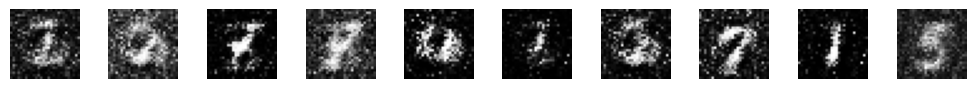

Epoch 1 start


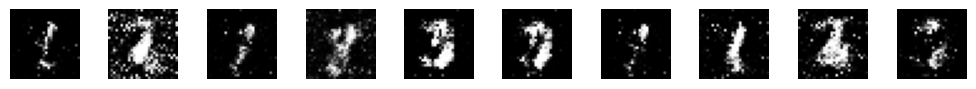

Epoch 2 start
Epoch 3 start
Epoch 4 start
Epoch 5 start
Epoch 6 start
Epoch 7 start
Epoch 8 start
Epoch 9 start
Epoch 10 start


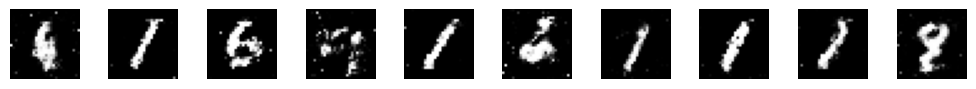

Epoch 11 start
Epoch 12 start
Epoch 13 start
Epoch 14 start
Epoch 15 start
Epoch 16 start
Epoch 17 start
Epoch 18 start
Epoch 19 start
Epoch 20 start


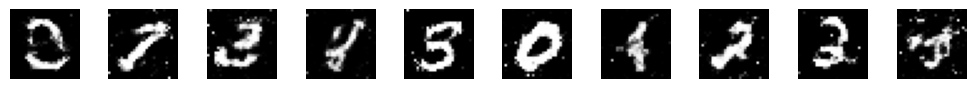

Epoch 21 start
Epoch 22 start
Epoch 23 start
Epoch 24 start
Epoch 25 start
Epoch 26 start
Epoch 27 start
Epoch 28 start
Epoch 29 start
Epoch 30 start


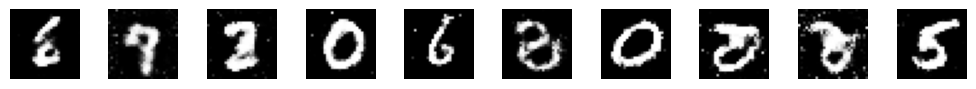

Epoch 31 start
Epoch 32 start
Epoch 33 start
Epoch 34 start
Epoch 35 start
Epoch 36 start
Epoch 37 start
Epoch 38 start
Epoch 39 start
Epoch 40 start


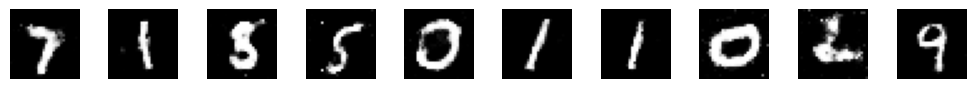

Epoch 41 start
Epoch 42 start
Epoch 43 start
Epoch 44 start
Epoch 45 start
Epoch 46 start
Epoch 47 start
Epoch 48 start
Epoch 49 start
Epoch 50 start


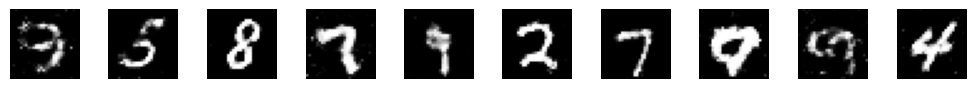

Epoch 51 start
Epoch 52 start
Epoch 53 start
Epoch 54 start
Epoch 55 start
Epoch 56 start
Epoch 57 start
Epoch 58 start
Epoch 59 start
Epoch 60 start


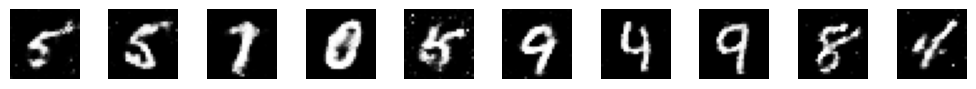

Epoch 61 start
Epoch 62 start
Epoch 63 start
Epoch 64 start
Epoch 65 start
Epoch 66 start
Epoch 67 start
Epoch 68 start
Epoch 69 start
Epoch 70 start


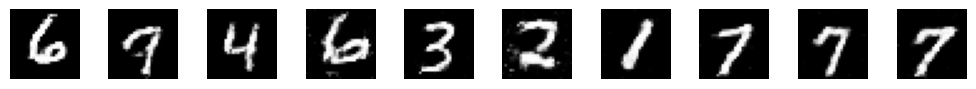

Epoch 71 start
Epoch 72 start
Epoch 73 start
Epoch 74 start
Epoch 75 start
Epoch 76 start
Epoch 77 start
Epoch 78 start
Epoch 79 start
Epoch 80 start


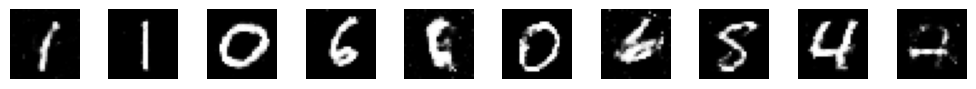

Epoch 81 start
Epoch 82 start
Epoch 83 start
Epoch 84 start
Epoch 85 start
Epoch 86 start
Epoch 87 start
Epoch 88 start
Epoch 89 start
Epoch 90 start


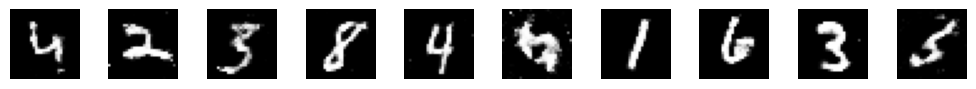

Epoch 91 start
Epoch 92 start
Epoch 93 start
Epoch 94 start
Epoch 95 start
Epoch 96 start
Epoch 97 start
Epoch 98 start
Epoch 99 start


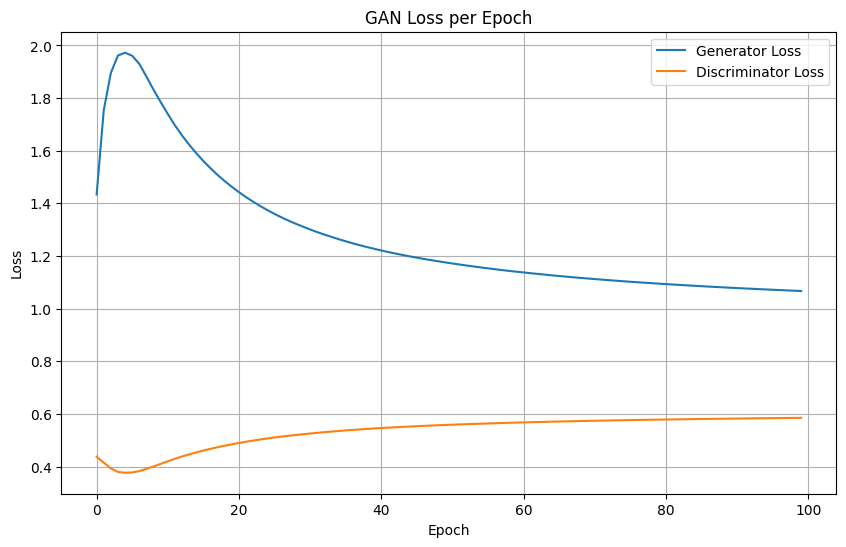

In [ ]:
#모델 학습후 진행상황들 저장
history = train_gan(generator = generator,
          discriminator = discriminator,
          gan = gan,
          latent_dim = latent_dim,
          epochs=100,
          batch_size=128)
#loss 그래프 출력
plot_loss(history)

In [ ]:
#학습된 모델 저장
import os
#저장 경로 지정
save_dir = "/content/drive/MyDrive/GAN_models"
os.makedirs(save_dir, exist_ok=True) #save_dir에 해당 파일이 없으면 생성

# 3. 모델 저장
generator.save(os.path.join(save_dir, 'generator_model.h5'))
discriminator.save(os.path.join(save_dir, 'discriminator_model.h5'))

generator.save(os.path.join(save_dir, 'generator_model.keras'))
discriminator.save(os.path.join(save_dir, 'discriminator_model.keras'))

# 저장된 GAN 사용 및 재학습

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU)
from tensorflow.keras.models import Sequential, Model

from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.datasets import mnist ## mnist 데이터셋
# (train_data, train_label), (test_data, test_label) = mnist.load_data()
# -> mnist에 저장된 train,과 test에 사용할 데이터와 정답을 (train_data, train_label), (test_data, test_label)에 저장함을 의미
#-> GAN에서는 train_data만 사용
(train_data, _), (_, _) = mnist.load_data()
train_data = (train_data.astype(np.float32) - 127.5) / 127.5  # 픽셀값은 0-255 -> [-1, 1] 범위의 픽셀값 생성

Mounted at /content/drive
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


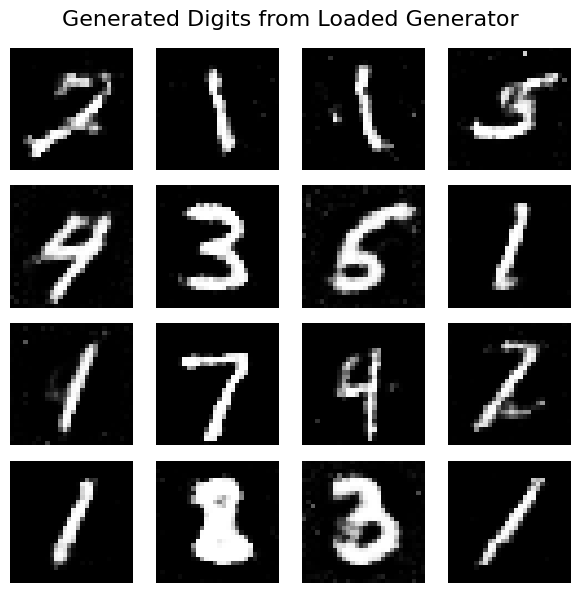

In [2]:
# 학습된 모델 사용
from tensorflow.keras.models import load_model
generator_saved = load_model('/content/drive/MyDrive/GAN_models/generator_model.h5')
discriminator_saved = load_model('/content/drive/MyDrive/GAN_models/discriminator_model.h5')

# 무작위 노이즈 생성
latent_dim = 10
noise = np.random.normal(0, 1, (16, latent_dim))  # 16개의 이미지 생성

# 노이즈를 통해 이미지 생성
generated_images = generator_saved.predict(noise)

#시각화
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Generated Digits from Loaded Generator', fontsize=16)
plt.tight_layout()
plt.show()

In [3]:
#훈련에 필요한 함수들

# 생성된 이미지 시각화 함수
def visualize_generated_images(generator, latent_dim, epoch): #generator = GAN의 생성자 모델, latent_dim=생성자 모델이 입력으로 받는 잠재공간의 차원
    noise = np.random.normal(0, 1, (10, latent_dim)) #생성자에 사용할 size = latent_dim인 10개의 노이즈 생성
    generated_images = generator.predict(noise, verbose = 0)  #noise로 부터 predict를 통해 이미지 생성
    plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# GAN 훈련 함수
def train_gan(generator, discriminator, gan, latent_dim, epochs, batch_size=128):
    batchCount = int(train_data.shape[0] / batch_size)
    print('Epochs : ', epochs)
    print('Batch Size : ', batch_size)
    print('Batches per Epoch : ', batchCount)
    g_losses = [] ## 생성기 loss
    d_losses = [] ## 판별기 loss
    for epoch in range(epochs):
      print ('Epoch %d start' % epoch)
      for _ in range(batchCount):
        # 임의의 노이즈에서 새로운 이미지 생성
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise, verbose = 0)

        # 진짜 이미지와 가짜 이미지 결합
        real_images = train_data[np.random.randint(0, train_data.shape[0], batch_size)] #훈련세트에서 무작위로 배치 사이즈 만큼의 진짜 이미지를 선택
        combined_images = np.concatenate([generated_images, real_images])  #concatenate는 생성된 이미지와 진짜 이미지를 하나의 배열로 결합

        # 레이블 정의
        labels = np.concatenate([np.zeros(batch_size), np.ones(batch_size)]) #가짜 이미지에 대한 레이블=0, 진짜 이미지에 대한 레이블=1을 생성

        # 판별자 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(combined_images, labels) #train_on_batch는 한 배치에 대해 판별자를 훈련, 손실값을 저장

        # 생성자

        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        misleading_targets = np.ones(batch_size)    #모든 값이 1로 설정 -> 판별자를 속이기 위해 설정
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, misleading_targets) #진짜 이미지와 노이즈에 대한 loss를 줄이는 방향으로 훈련

     #판별자와 생성자의 loss를 저장
      d_losses.append(d_loss)
      g_losses.append(g_loss)

      if epoch == 1 or epoch % 2 == 0: #2epoch마다 출력
         visualize_generated_images(generator, latent_dim, epoch)
    return {'d_loss': d_losses, 'g_loss': g_losses}

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['g_loss'], label='Generator Loss')
    plt.plot(history['d_loss'], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Epochs :  5
Batch Size :  128
Batches per Epoch :  468
Epoch 0 start


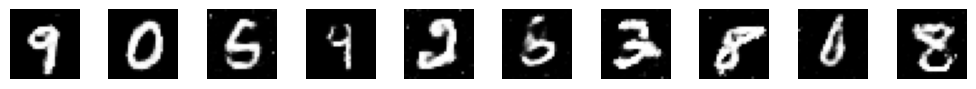

Epoch 1 start


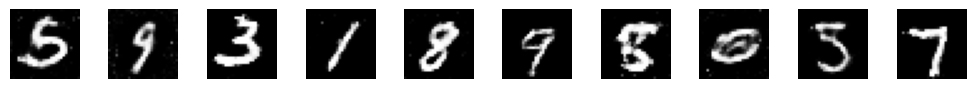

Epoch 2 start


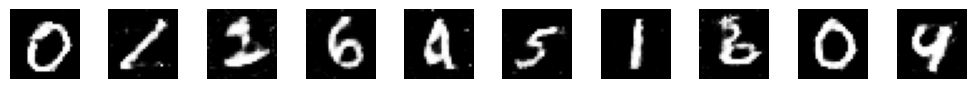

Epoch 3 start
Epoch 4 start


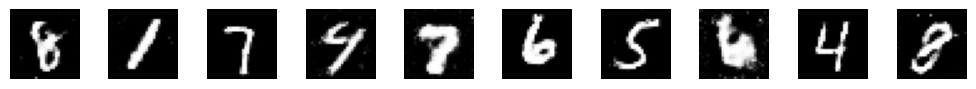

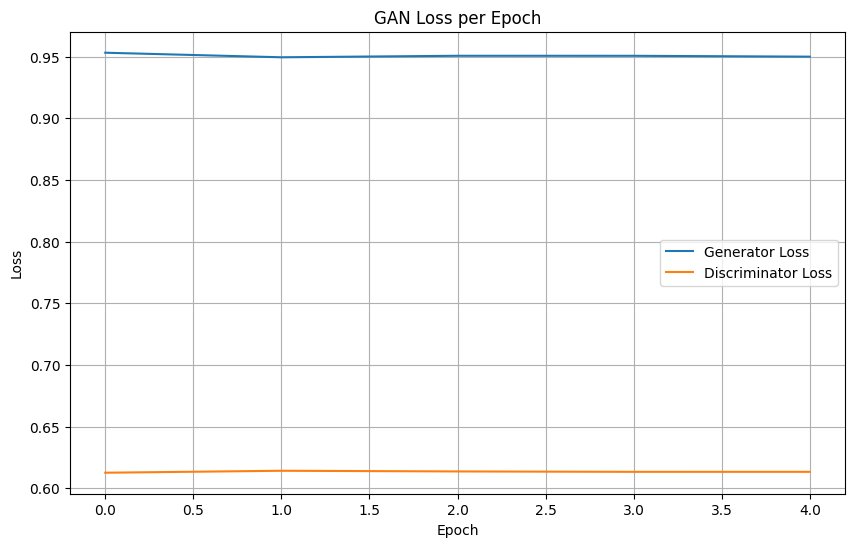

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model, Input


discriminator_saved.trainable = False

#latent_dim -> 이전에 학습된 모델과 같은 구조를 사용 -> input_size에 해당하는 latent_dim는 이전의 값과 동일
latent_dim = 10

# GAN 구성
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator_saved(generator_saved(gan_input))  #저장된 생산자와 판별자로 GAN 구성
gan_2 = Model(gan_input, gan_output)

# optimizer설정 (오류 방지를 위해 학습에 사용하지 않은 새로운 optimizer 사용 )
adam_gan_2 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
adam_dis_2 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

rms_gan = tf.keras.optimizers.RMSprop(learning_rate=0.0002)
rms_dis = tf.keras.optimizers.RMSprop(learning_rate=0.0002)

discriminator_saved.compile(loss='binary_crossentropy', optimizer=adam_dis_2)
gan_2.compile(loss='binary_crossentropy', optimizer=adam_gan_2)


#이전에 정의한 train function을 그대로 사용
history_2 = train_gan(generator = generator_saved,
                    discriminator = discriminator_saved,
                    gan = gan_2,
                    latent_dim = latent_dim,
                    epochs=5,
                    batch_size=128)
plot_loss(history_2)